In [1]:
import math
import random

import numpy as np
from numba import cuda, int32, jit
from tabulate import tabulate

import time
import datetime

import matplotlib.pyplot as plt

In [2]:
# Расчет будет производиться на блоках элементов TPBxTPB
TPB = 16
# Количество итераций для вычисления среднего затраченного времени
ITER_COUNT = 10

In [3]:
#Функция создания матриц MxM
def create_matrix (M):
  A = np.random.randint(1000, size=(M,M))
  B = np.random.randint(1000, size=(M,M))
  C = np.zeros((M, M), dtype=np.int32)
  return (A, B, C)

In [4]:
M = 100
A, B, C = create_matrix (M)
print("A", A, "\n", "B", B, "\n", "C", C)

A [[248 818 381 ... 781 852 221]
 [346 238 217 ...  36 765 748]
 [505 304 341 ... 360 191 993]
 ...
 [359  11 296 ... 470 569 240]
 [454 771 960 ... 499 471 937]
 [571 462 847 ... 701 600 380]] 
 B [[279  18 480 ... 971 950 341]
 [527 693 499 ... 115 463 465]
 [246 877 537 ...  19 490 389]
 ...
 [104 356 236 ...  86 221 341]
 [327 636 859 ... 231 825 687]
 [ 75 378 380 ... 539 228 313]] 
 C [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
# стартовое время
start_time = datetime.datetime.now()
C1 = A.dot(B)
# затраченное время
t1 = datetime.datetime.now() - start_time
print(C1)
print ('time:  '+ str(t1))

[[22542088 22978707 22267734 ... 24119089 20582521 24113857]
 [25713707 26191390 25051566 ... 28226974 24517057 27173385]
 [25526977 27579037 24420102 ... 27776585 25247163 27226278]
 ...
 [24493152 25053305 24913124 ... 26985602 25038058 26345878]
 [23203356 25305222 22803487 ... 25819648 25170062 26293179]
 [27911321 27441622 24032930 ... 27775440 26668455 28303810]]
time:  0:00:00.001011


In [8]:
#Динамический компилятор Cuda
@cuda.jit
def matrix_mult_GPU(d_a, d_b, d_c):
  # определяем массив в общей памяти
  shared_a = cuda.shared.array(shape=(TPB, TPB), dtype=int32)
  shared_b = cuda.shared.array(shape=(TPB, TPB), dtype=int32)

  x, y = cuda.grid(2)

  # Набор встроенных функций CUDA используется для идентификации текущего потока выполнения (используются только внутри ядра CUDA или функции устройства)
  t_x = cuda.threadIdx.x
  t_y = cuda.threadIdx.y
  # количество блоков на сетку
  bpg = cuda.gridDim.x

  # Проверка на выход границы
  if x >= d_c.shape[0] and y >= d_c.shape[1]:
    return

  # каждый поток вычисляет один элемент в итоговой матрице, произведение разбивается на произведения векторов длиной TPB
  tmp = 0.
  for i in range(bpg):
    # загружаем данные в общую память
    shared_a[t_x, t_y] = d_a[x, t_y + i * TPB]
    shared_b[t_x, t_y] = d_b[t_x + i * TPB, y]

    # ожидание окончания предварительной загрузки
    cuda.syncthreads()

    # вычисление в общей памяти
    for j in range(TPB):
      tmp += shared_a[t_x, j] * shared_b[j, t_y]

    # Ожидание окончания вычисления на всех потоках
    cuda.syncthreads()
  d_c[x, y] = tmp

In [9]:
def body_GPU(grid_size, block_size, d_a, d_b, d_c):
  # Перенос данных в глобальную память GPU
  d_a = cuda.to_device(A)
  d_b = cuda.to_device(B)
  d_c = cuda.to_device(C)

  # вызов ядра
  matrix_mult_GPU[grid_size, block_size](d_a, d_b, d_c)
  # Перенос вывода с устройства на хост
  GPU_C = d_c.copy_to_host()
  return GPU_C

In [10]:
grid_size = (10, 10)
block_size = (16, 16)
# стартовое время
start_time = datetime.datetime.now()
GPU_C1 = body_GPU (grid_size, block_size, A, B, C)
# затраченное время
t3 = datetime.datetime.now() - start_time

print(GPU_C1)
print ('time:  '+ str(t3))

C:\Users\bambu\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:538: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[[  22542088   22978707   22267734 ... 2147483647 2147483647 2147483647]
 [2147483647 2147483647 2147483647 ... 2147483647 2147483647 2147483647]
 [2147483647 2147483647 2147483647 ... 2147483647 2147483647 2147483647]
 ...
 [2147483647 2147483647 2147483647 ... 2147483647 2147483647 2147483647]
 [2147483647 2147483647 2147483647 ... 2147483647 2147483647 2147483647]
 [2147483647 2147483647 2147483647 ...   27775440   26668455   28303810]]
time:  0:00:00.604165


In [12]:
result_list = []
# размер матриц по условию от 100x100 до 2000х2000,
# расчет производится на блоках элементов TPBxTPB (т.е. 16x16)
# Количество итераций для вычисления среднего затраченного времени ITER_COUNT = 10

for bpg in range(10, 140, 15):
  grid_size = (bpg, bpg)
  block_size = (TPB, TPB)

  # размер матрицы
  M = bpg * TPB

  correct_result = True

  dot_time_sum = 0
  cpu_time_sum = 0
  gpu_time_sum = 0

  for _ in range(ITER_COUNT):
    # создаем матрицы размера М
    A, B, C = create_matrix (M)

    # стартовое время
    start = time.time()
    CPU_C = A.dot(B)
    # затраченное время
    dot_time = time.time() - start
    dot_time_sum += dot_time

    # стартовое время
    start = time.time()

    GPU_C2 = body_GPU(grid_size, block_size, A, B, C)

    # затраченное время
    gpu_time = time.time() - start
    gpu_time_sum += gpu_time

    # для проверки правильности вычислений на GPU
    correct_result = np.array_equal(GPU_C2, CPU_C)

  res = [M, correct_result, dot_time_sum / ITER_COUNT, gpu_time_sum / ITER_COUNT]
  #print(res)
  result_list.append(res)

In [13]:

print(tabulate(result_list, headers=['Matrix size', 'Correct', 'CPU time', 'GPU time']))

  Matrix size  Correct       CPU time    GPU time
-------------  ---------  -----------  ----------
          160  True        0.00239592  0.00181949
          400  True        0.0422034   0.00580881
          640  True        0.296392    0.018476
          880  True        0.70721     0.0738686
         1120  True        1.70968     0.156883
         1360  True        3.19163     0.2852
         1600  True       10.4198      0.368447
         1840  True       22.3236      0.542719
         2080  True       34.9037      0.633081


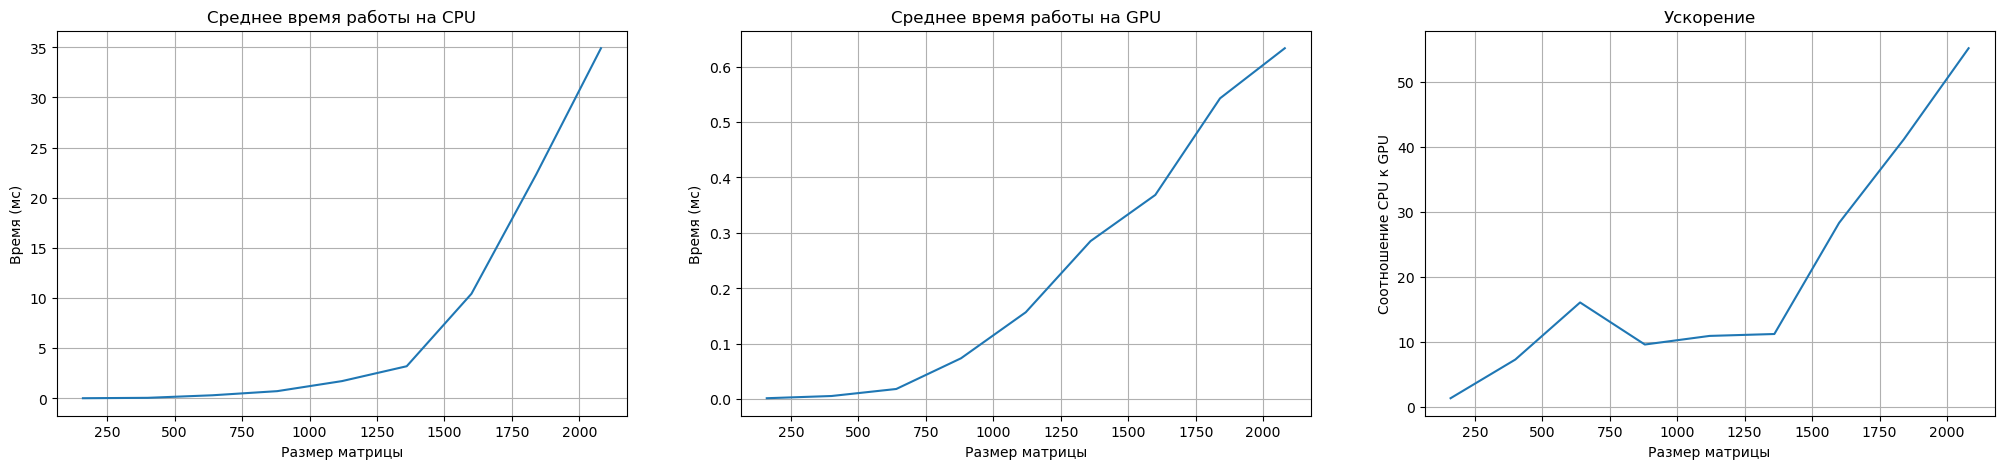

In [14]:
result_matr = np.array(result_list)
plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.title('Среднее время работы на CPU')
plt.plot(result_matr[:, 0], result_matr[:, 2])
plt.xlabel('Размер матрицы')
plt.ylabel('Время (мс)')
plt.grid()

plt.subplot(1, 3, 2)
plt.title('Среднее время работы на GPU')
plt.plot(result_matr[:, 0], result_matr[:, 3])
plt.xlabel('Размер матрицы')
plt.ylabel('Время (мс)')
plt.grid()

plt.subplot(1, 3, 3)
plt.title('Ускорение')
plt.plot(result_matr[:, 0], (result_matr[:, 2]/result_matr[:, 3]))
plt.xlabel('Размер матрицы')
plt.ylabel('Соотношение CPU к GPU')
plt.grid()
     